In [1]:
import os
import cv2
import glob
import tqdm
import matplotlib.pyplot as plt
import json
import numpy as np
import imageio

In [2]:
# After run data_process/process_video.py
# you can visualize processed data in this script
base_dir = 'vid/Obama256'
FPS = 25 # same as your original video
vis_len = 500 # how many frames to check

tmp_dir = 'tmp/'
os.makedirs(tmp_dir, exist_ok=True)

Read Original Images: 100%|██████████| 500/500 [00:01<00:00, 421.49it/s]


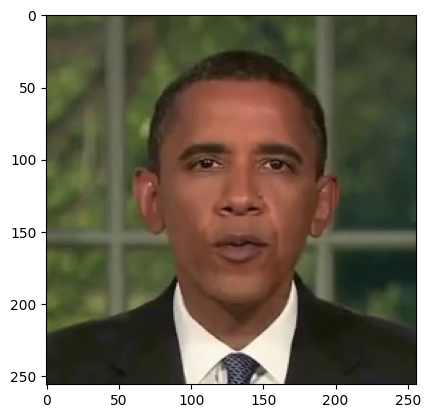

In [3]:
# Original Images
image_paths = glob.glob(os.path.join(base_dir, 'ori_imgs', '*.jpg'))
image_paths = sorted(image_paths, key=lambda x: int(x.split('/')[-1].split('.')[0]))
image_paths = image_paths[:vis_len]
ori_imgs = []
for image_path in tqdm.tqdm(image_paths, desc='Read Original Images'):
    bgr_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    ori_imgs.append(rgb_image)
plt.imshow(ori_imgs[0])
h , w = ori_imgs[0].shape[:2]

In [4]:
# Mediapipe Mesh
def json_load(json_path:str):
    with open(json_path, 'r') as fp:
        data = json.load(fp)
    return data
face_meshs = json_load(os.path.join(base_dir, 'ori_imgs', 'face_mesh.json'))
face_poses = json_load(os.path.join(base_dir, 'ori_imgs', 'face_poses.json'))
nodes_points = json_load(os.path.join(base_dir, 'ori_imgs', 'nodes_points.json'))
camera_poses = json_load(os.path.join(base_dir, 'ori_imgs', 'camera_poses.json'))
print(f'face_mesh: {len(face_meshs["0"])} landmarks')
print(f'face_pose: {face_poses["0"]}')
print(f'nodes_point: {nodes_points["0"]}')
print(f'camera_pose: {camera_poses["0"]}')

print(f'valid ids len: {len(face_poses)}')

face_mesh: 468 landmarks
face_pose: [[0.9990160719447367, 0.015535974122874328, 0.041539397012502845, 0.745492906561613], [0.015881115019569014, -0.9998419489491145, -0.007991702407591492, -0.33152719285464005], [0.041408672785349813, 0.008643531089182446, -0.9991049049967006, 37.313041106210946], [0.0, 0.0, 0.0, 1.0]]
nodes_point: [[135, 128], [165, 116]]
camera_pose: [[0.9990160719447367, 0.015881115019569014, 0.041408672785349813, 2.284577883487404], [0.015535974122874328, -0.9998419489491145, 0.008643531089182446, 0.6655731839720167], [0.041539397012502845, -0.007991702407591492, -0.9991049049967006, -37.24602559707789], [0.0, 0.0, 0.0, 1.0]]
valid ids len: 8000


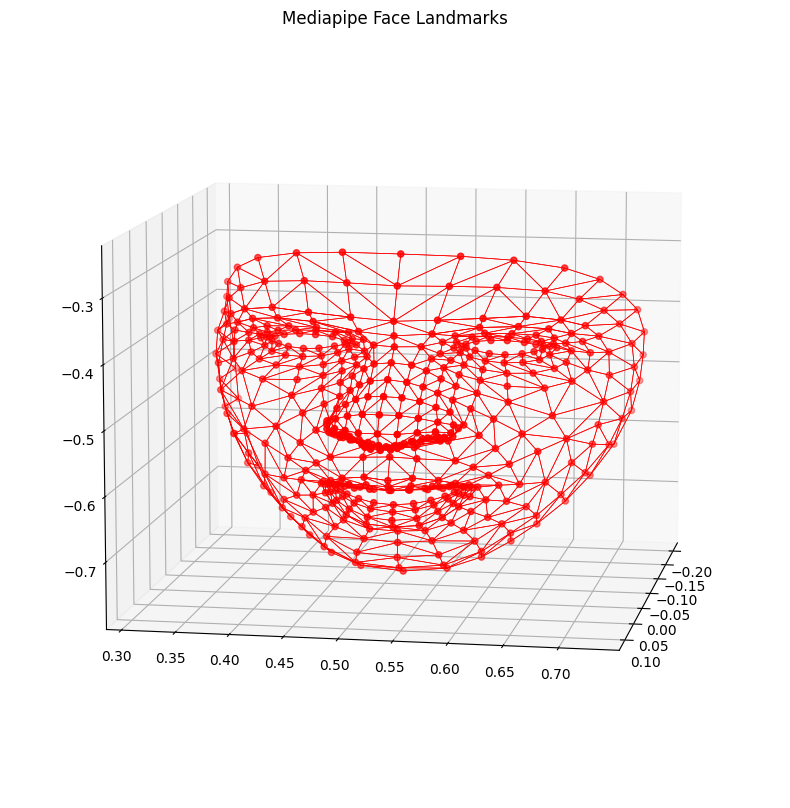

In [5]:
from utils.spatial3d import transform_3d_points
from data_process.face_mesh import pltplot_landmarks, load_pltplot_resize_and_corp
mesh_0 = face_meshs["0"]
rotation_0 = face_poses["0"]
pltplot_landmarks(mesh_0, desc='Mediapipe Face Landmarks')
# pltplot_landmarks(mesh_0, rotation_matrix=rotation_0, desc='Mediapipe Mesh')
#TODO face_poses, nose, camera_poses

In [6]:
mesh_imgs = []
mesh_imgs = []
angles = np.linspace(-30, 30, vis_len)
for image_path, angle in tqdm.tqdm(zip(image_paths, angles), desc='Plot Mesh'):
    _ = os.path.basename(image_path)
    img_id = os.path.splitext(_)[0]
    tmp_fig = os.path.join(tmp_dir, f'{img_id}_meshplt.png')
    try:
        if not os.path.exists(tmp_fig):
            pltplot_landmarks(landmarks=face_meshs[img_id], 
                            fig_path=tmp_fig,
                            azimuth=angle,
                            desc='Mediapipe Face Landmarks')
        mesh_img = load_pltplot_resize_and_corp(tmp_fig, h, w)
    except:
        print(f'Plot mesh {img_id} fail')
        mesh_img = np.zeros((h, w, 3)) + 255
    mesh_imgs.append(mesh_img)

Plot Mesh: 500it [00:05, 85.08it/s]


In [7]:
# Face Parsed
parsed_imgs = []
from data_process.face_parsing import visualize_parsing_maps
for i, image_path in enumerate(tqdm.tqdm(image_paths, desc='Plot Face Semantic')):
    _ = os.path.basename(image_path)
    img_id = os.path.splitext(_)[0]
    parsed_path = os.path.join(base_dir, 'parsing', f'{img_id}.npy')
    parsed = np.load(parsed_path)
    parsed_imgs.append(visualize_parsing_maps(ori_imgs[i], parsed, debug=False))

Plot Face Semantic: 100%|██████████| 500/500 [00:02<00:00, 184.01it/s]


In [8]:
# Background, head, torso, gt 

In [9]:
# Depth

In [10]:
def expand_image(image:np.ndarray, frame_size:int=1):
    old_h, old_w, c = image.shape
    frame_size = int(frame_size)
    new_h = old_h + 2 * frame_size
    new_w = old_w + 2 * frame_size

    expanded_image = np.zeros((new_h, new_w, c), dtype=image.dtype) + 255
    expanded_image[frame_size:-frame_size, frame_size:-frame_size, :] = image
    return expanded_image

def load_image(image_path, h, w):
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img.shape[:2] != (h, w):
            img= cv2.resize(img, (w, h)) 
        return img
    except:
        print(f'Fail to load {image_path}')
        return np.zeros((h,w,3)) + 255

def save_to_video(image_list, video_path):
    to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)
    rgbs = []
    for images in tqdm.tqdm(zip(*image_list), desc='Write Video'):
        new_imgs = [expand_image(p) for p in images]
        concatenated_image = np.concatenate(new_imgs, axis=1).astype(np.uint8)
        rgbs.append(concatenated_image)

    # set video writer 
    imageio.mimsave(video_path, rgbs, fps=FPS, quality=8)

video_path = f'{tmp_dir}/vis_woaudio.mp4'
save_to_video([ori_imgs, mesh_imgs, parsed_imgs], video_path=video_path)


Write Video: 500it [00:00, 3271.12it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (774, 258) to (784, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6d9ae00] Warning: data is not aligned! This can lead to a speed loss


In [11]:
# Uncomment to install ffmpeg if not done
# !sudo apt-get install -y ffmpeg
# clip audio
audio_path = os.path.join(base_dir, 'audio.wav')
clip_path = os.path.join(tmp_dir, 'clip.wav')
start_time = 0
end_time = vis_len/FPS
os.system(f'ffmpeg -i {audio_path} -ss {start_time} -to {end_time} -c copy {clip_path}')

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0

In [12]:
video_path_final = os.path.join(base_dir, 'vis-data.mp4')
os.system(f'ffmpeg -i {video_path} -i {clip_path} -c:v copy -c:a aac -map 0:v:0 -map 1:a:0 {video_path_final}')


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0